In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Read all Excel files and combine them
all_data = []
data_path = Path('datasets/2000')

# Read all gm-okr files
for i in range(1, 69):  # gm-okr01.xls to gm-okr68.xls
    file_path = data_path / f'gm-okr{i:02d}.xls'
    if file_path.exists():
        try:
            df = pd.read_excel(file_path)
            all_data.append(df)
            print(f"Loaded {file_path.name}")
        except Exception as e:
            print(f"Error loading {file_path.name}: {e}")

# Combine all data
election_data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal municipalities loaded: {len(election_data)}")

# Get candidate columns (all columns after 'Głosy ważne')
candidate_columns = list(election_data.columns[10:])  # Starting from the 11th column
print("\nCandidates:", candidate_columns)

# Calculate total votes for each candidate
total_votes = {}
for candidate in candidate_columns:
    total_votes[candidate] = election_data[candidate].sum()

# Sort candidates by total votes and get top 2
sorted_candidates = sorted(total_votes.items(), key=lambda x: x[1], reverse=True)
top_2_candidates = [sorted_candidates[0][0], sorted_candidates[1][0]]
print(f"\nTop 2 candidates:")
print(f"1. {top_2_candidates[0]}: {sorted_candidates[0][1]:,} votes")
print(f"2. {top_2_candidates[1]}: {sorted_candidates[1][1]:,} votes")

# For each municipality, determine which of the top 2 candidates won
election_data['winner'] = election_data.apply(
    lambda row: top_2_candidates[0] if row[top_2_candidates[0]] > row[top_2_candidates[1]]
    else top_2_candidates[1], axis=1
)

# Count wins per candidate
wins_count = election_data['winner'].value_counts()
print(f"\nMunicipalities won:")
for candidate, count in wins_count.items():
    print(f"{candidate}: {count}")


In [ ]:
# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)

# Check available columns
print("Available columns in GML file:")
print(municipalities.columns.tolist())

# Check if JPT_NAZWA_ exists
if 'JPT_NAZWA_' in municipalities.columns:
    print(f"\nFound JPT_NAZWA_ column with {municipalities['JPT_NAZWA_'].notna().sum()} non-null values")
    print("Sample municipality names from GML:", municipalities['JPT_NAZWA_'].head(10).tolist())

# Prepare municipality names for merging
# Clean and standardize names
election_data['Gmina_clean'] = election_data['Gmina'].str.strip().str.upper()
municipalities['JPT_NAZWA_clean'] = municipalities['JPT_NAZWA_'].str.strip().str.upper()

# First attempt: direct merge on cleaned names
merged = municipalities.merge(
    election_data[['Gmina_clean', 'winner', top_2_candidates[0], top_2_candidates[1]]],
    left_on='JPT_NAZWA_clean',
    right_on='Gmina_clean',
    how='left'
)

print(f"\nMatched municipalities: {merged['winner'].notna().sum()} out of {len(merged)}")

# If we have poor matching, let's check for unmatched municipalities
if merged['winner'].notna().sum() < len(election_data) * 0.8:
    print("\nChecking for unmatched municipalities...")

    # Find unmatched election data
    unmatched_election = set(election_data['Gmina_clean']) - set(merged[merged['winner'].notna()]['Gmina_clean'])
    print(f"Unmatched from election data: {len(unmatched_election)}")
    if len(unmatched_election) < 20:
        print("Examples:", list(unmatched_election)[:20])

    # Find unmatched GML municipalities
    unmatched_gml = merged[merged['winner'].isna()]['JPT_NAZWA_clean'].unique()
    print(f"\nUnmatched from GML: {len(unmatched_gml)}")
    if len(unmatched_gml) < 20:
        print("Examples:", list(unmatched_gml)[:20])


In [ ]:
# If matching is still poor, try fuzzy matching for common issues
def improve_matching(merged, election_data, municipalities):
    # Handle city districts (e.g., "Kraków" might be split into districts)
    unmatched_election = election_data[~election_data['Gmina_clean'].isin(
        merged[merged['winner'].notna()]['Gmina_clean']
    )]

    # For each unmatched municipality in election data, try to find a match
    for idx, row in unmatched_election.iterrows():
        gmina_name = row['Gmina_clean']

        # Try exact match first
        mask = municipalities['JPT_NAZWA_clean'] == gmina_name

        # If no exact match, try partial match
        if not mask.any():
            # Check if it's a city district (contains 'm.')
            if 'M.' in gmina_name:
                city_name = gmina_name.replace('M.', '').strip()
                mask = municipalities['JPT_NAZWA_clean'].str.contains(city_name, na=False)
            else:
                # Check if the GML name contains the election name or vice versa
                mask = municipalities['JPT_NAZWA_clean'].str.contains(gmina_name, na=False) | \
                       municipalities['JPT_NAZWA_clean'].apply(lambda x: x in gmina_name if pd.notna(x) else False)

        # If we found a match, update the merged dataframe
        if mask.any():
            matched_idx = municipalities[mask].index[0]
            if pd.isna(merged.loc[matched_idx, 'winner']):
                merged.loc[matched_idx, 'winner'] = row['winner']
                merged.loc[matched_idx, top_2_candidates[0]] = row[top_2_candidates[0]]
                merged.loc[matched_idx, top_2_candidates[1]] = row[top_2_candidates[1]]
                merged.loc[matched_idx, 'Gmina_clean'] = row['Gmina_clean']

    return merged

# Try to improve matching if needed
if merged['winner'].notna().sum() < len(election_data) * 0.9:
    print("\nAttempting to improve matching...")
    merged = improve_matching(merged, election_data, municipalities)
    print(f"After improvement: {merged['winner'].notna().sum()} matched out of {len(merged)}")


In [ ]:
# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {top_2_candidates[0]: '#FF0000', top_2_candidates[1]: '#0000FF'}  # Red and Blue

# Plot municipalities with no data in gray
merged[merged['winner'].isna()].plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    merged[merged['winner'] == candidate].plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title and legend
plt.title('Polish Presidential Election 2000 - Top 2 Candidates by Municipality', fontsize=16, pad=20)

# Create custom legend with vote totals
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[top_2_candidates[0]],
          label=f'{top_2_candidates[0]}\n{sorted_candidates[0][1]:,} votes ({wins_count.get(top_2_candidates[0], 0)} gminas)'),
    Patch(facecolor=colors[top_2_candidates[1]],
          label=f'{top_2_candidates[1]}\n{sorted_candidates[1][1]:,} votes ({wins_count.get(top_2_candidates[1], 0)} gminas)'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Remove axes
ax.set_axis_off()

# Adjust layout
plt.tight_layout()
plt.show()

# Create a detailed visualization with vote margins
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Map 1: Winner by municipality
merged[merged['winner'].isna()].plot(ax=ax1, color='lightgray', edgecolor='black', linewidth=0.1)
for candidate, color in colors.items():
    merged[merged['winner'] == candidate].plot(ax=ax1, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

ax1.set_title(f'Winner by Municipality\n{top_2_candidates[0]} (Red) vs {top_2_candidates[1]} (Blue)', fontsize=14)
ax1.set_axis_off()

# Add legend to first map
legend_elements1 = [
    Patch(facecolor=colors[top_2_candidates[0]], label=top_2_candidates[0]),
    Patch(facecolor=colors[top_2_candidates[1]], label=top_2_candidates[1]),
    Patch(facecolor='lightgray', label='No data')
]
ax1.legend(handles=legend_elements1, loc='upper right', fontsize=10)

# Map 2: Vote margin (intensity of color shows margin of victory)
# Calculate vote margin as percentage
merged['vote_margin'] = merged.apply(
    lambda row: ((row[top_2_candidates[0]] - row[top_2_candidates[1]]) /
                 (row[top_2_candidates[0]] + row[top_2_candidates[1]]) * 100)
    if pd.notna(row['winner']) else np.nan, axis=1
)

# Plot municipalities with no data in gray
merged[merged['winner'].isna()].plot(ax=ax2, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot with color gradient
merged_with_data = merged[merged['winner'].notna()]
im = merged_with_data.plot(column='vote_margin', cmap='RdBu_r', edgecolor='black', linewidth=0.1,
                           ax=ax2, legend=False, vmin=-100, vmax=100)

ax2.set_title('Vote Margin Between Top 2 Candidates\n(Red = ' + top_2_candidates[0] + ', Blue = ' + top_2_candidates[1] + ')', fontsize=14)
ax2.set_axis_off()

# Add colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
sm = ScalarMappable(cmap='RdBu_r', norm=Normalize(vmin=-100, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.7)
cbar.set_label(f'← {top_2_candidates[1]} wins by % | {top_2_candidates[0]} wins by % →', fontsize=10)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY STATISTICS")
print("="*60)
print(f"Total votes cast: {election_data['Głosy ważne'].sum():,}")
print(f"Total municipalities in election data: {len(election_data)}")
print(f"Successfully mapped municipalities: {merged['winner'].notna().sum()}")
print(f"\nNational vote share:")
total_valid_votes = election_data['Głosy ważne'].sum()
for i, (candidate, votes) in enumerate(sorted_candidates[:5]):  # Show top 5 candidates
    percentage = (votes / total_valid_votes) * 100
    print(f"{i+1}. {candidate}: {votes:,} votes ({percentage:.1f}%)")


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the 2005 election data
file_path = 'datasets/2005/2005.xls'
election_data_2005 = pd.read_excel(file_path, skiprows=2)

# Set column names
election_data_2005.columns = [
    'TERYT', 'Gmina', 'Powiat',
    'Uprawnieni', 'Karty_wydane', 'Karty_wydane_proc',
    'Glosy_oddane', 'Glosy_niewazne', 'Glosy_niewazne_proc',
    'Glosy_wazne', 'Glosy_wazne_proc',
    'Kaczynski_liczba', 'Kaczynski_proc',
    'Tusk_liczba', 'Tusk_proc'
]

# Clean the data
election_data_2005 = election_data_2005[election_data_2005['TERYT'].notna()]
election_data_2005['TERYT'] = election_data_2005['TERYT'].astype(str).str.strip().str.zfill(6)

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)

# Clean and prepare TERYT codes - take only first 6 digits from GML file
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]
election_data_2005['TERYT_6'] = election_data_2005['TERYT']

# Determine winner for each municipality
election_data_2005['winner'] = election_data_2005.apply(
    lambda row: 'Kaczyński' if row['Kaczynski_liczba'] > row['Tusk_liczba'] else 'Tusk',
    axis=1
)

# Merge using first 6 digits of TERYT codes
merged = municipalities.merge(
    election_data_2005[['TERYT_6', 'Gmina', 'winner', 'Kaczynski_liczba',
                       'Tusk_liczba', 'Kaczynski_proc', 'Tusk_proc']],
    on='TERYT_6',
    how='left'
)

print(f"Matched municipalities: {merged['winner'].notna().sum()} out of {len(election_data_2005)}")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {'Kaczyński': '#FF0000', 'Tusk': '#0000FF'}  # Red for Kaczyński, Blue for Tusk

# Plot municipalities with no data in gray
no_data = merged[merged['winner'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    candidate_data = merged[merged['winner'] == candidate]
    if len(candidate_data) > 0:
        candidate_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
plt.title('Polish Presidential Election 2005 (Second Round)\nLech Kaczyński vs Donald Tusk',
          fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Kaczyński'],
          label=f'Lech Kaczyński'),
    Patch(facecolor=colors['Tusk'],
          label=f'Donald Tusk'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Debug unmatched municipalities
if merged['winner'].notna().sum() < len(election_data_2005) * 0.8:
    print("\nInvestigating matches:")
    print("\nSample of successful matches:")
    matched = merged[merged['winner'].notna()].head(10)
    print("\nTERYT codes and names for matched municipalities:")
    print(matched[['JPT_KOD_JE', 'TERYT_6', 'JPT_NAZWA_', 'Gmina']].to_string())

    print("\nSample of unmatched municipalities from election data:")
    matched_teryts = set(merged[merged['winner'].notna()]['TERYT_6'])
    unmatched = election_data_2005[~election_data_2005['TERYT_6'].isin(matched_teryts)]
    print(unmatched[['TERYT', 'Gmina']].head(10))

    print("\nSample of unmatched municipalities from GML:")
    unmatched_gml = merged[merged['winner'].isna()]['JPT_KOD_JE'].head(10)
    print(unmatched_gml)


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the 2010 election data with proper encoding
file_path = 'datasets/2010/pzt2010-wyn-gmn.csv'
election_data_2010 = pd.read_csv(file_path, sep=';', encoding='cp1250')

# Clean column names
election_data_2010.columns = [
    'Kod_woj', 'Wojewodztwo', 'Kod_gm', 'Gmina', 'Typ_gminy', 'Powiat',
    'L_obwodow', 'Uprawnieni', 'Wydane_karty', 'Glosy_oddane', 'Glosy_wazne',
    'Kaczynski_glosy', 'Komorowski_glosy'
]

# Create TERYT code by combining wojewodztwo and gmina codes
election_data_2010['TERYT'] = election_data_2010['Kod_gm'].astype(str).str.zfill(6)

# Determine winner for each municipality
election_data_2010['winner'] = election_data_2010.apply(
    lambda row: 'Kaczyński' if row['Kaczynski_glosy'] > row['Komorowski_glosy'] else 'Komorowski',
    axis=1
)

# Calculate total votes
total_kaczynski = election_data_2010['Kaczynski_glosy'].sum()
total_komorowski = election_data_2010['Komorowski_glosy'].sum()

print(f"\nElection Results 2010 (Second Round):")
print(f"Jarosław Kaczyński: {total_kaczynski:,} votes ({total_kaczynski/(total_kaczynski+total_komorowski)*100:.2f}%)")
print(f"Bronisław Komorowski: {total_komorowski:,} votes ({total_komorowski/(total_kaczynski+total_komorowski)*100:.2f}%)")

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)

# Clean and prepare TERYT codes - take only first 6 digits from GML file
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]
election_data_2010['TERYT_6'] = election_data_2010['TERYT']

# Merge using first 6 digits of TERYT codes
merged = municipalities.merge(
    election_data_2010[['TERYT_6', 'Gmina', 'winner', 'Kaczynski_glosy', 'Komorowski_glosy']],
    on='TERYT_6',
    how='left'
)

print(f"\nMatched municipalities: {merged['winner'].notna().sum()} out of {len(election_data_2010)}")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {'Kaczyński': '#FF0000', 'Komorowski': '#0000FF'}  # Red for Kaczyński, Blue for Komorowski

# Plot municipalities with no data in gray
no_data = merged[merged['winner'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    candidate_data = merged[merged['winner'] == candidate]
    if len(candidate_data) > 0:
        candidate_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
plt.title('Polish Presidential Election 2010 (Second Round)\nJarosław Kaczyński vs Bronisław Komorowski',
          fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Kaczyński'],
          label=f'Jarosław Kaczyński'),
    Patch(facecolor=colors['Komorowski'],
          label=f'Bronisław Komorowski'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Debug unmatched municipalities if needed
if merged['winner'].notna().sum() < len(election_data_2010) * 0.8:
    print("\nInvestigating matches:")
    print("\nSample of election data TERYT codes:")
    print(election_data_2010['TERYT'].head(10))
    print("\nSample of GML TERYT codes:")
    print(municipalities['TERYT_6'].head(10))


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the 2015 election data
file_path_2015 = 'datasets/2015/wyniki_tura2.xls'
election_data_2015 = pd.read_excel(file_path_2015)

# Group by municipality to get totals
municipality_results = election_data_2015.groupby('Gmina').agg({
    'Andrzej Sebastian Duda': 'sum',
    'Bronisław Maria Komorowski': 'sum'
}).reset_index()

# Determine winner for each municipality
municipality_results['winner'] = municipality_results.apply(
    lambda row: 'Duda' if row['Andrzej Sebastian Duda'] > row['Bronisław Maria Komorowski'] else 'Komorowski',
    axis=1
)

# Read the 2010 data to get TERYT codes
file_path_2010 = 'datasets/2010/pzt2010-wyn-gmn.csv'
data_2010 = pd.read_csv(file_path_2010, sep=';', encoding='cp1250')

# Create mapping dictionary from 2010 data
teryt_mapping = {}
for _, row in data_2010.iterrows():
    gmina_name = row['Gmina']
    if gmina_name.endswith(', m.'):
        gmina_name = 'm. ' + gmina_name[:-4]
    elif gmina_name.endswith(', gm.'):
        gmina_name = 'gm. ' + gmina_name[:-5]
    teryt_mapping[gmina_name] = str(row['Kod gm.']).zfill(6)

# Map TERYT codes to 2015 data
municipality_results['TERYT'] = municipality_results['Gmina'].map(teryt_mapping)

print("\nMapping statistics:")
print(f"Total municipalities in 2015: {len(municipality_results)}")
print(f"Municipalities with TERYT codes: {municipality_results['TERYT'].notna().sum()}")

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)

# Clean and prepare TERYT codes
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]
municipality_results['TERYT_6'] = municipality_results['TERYT']

# Merge using TERYT codes
merged = municipalities.merge(
    municipality_results[['TERYT_6', 'winner', 'Andrzej Sebastian Duda', 'Bronisław Maria Komorowski']],
    on='TERYT_6',
    how='left'
)

print(f"\nMatched municipalities: {merged['winner'].notna().sum()} out of {len(municipality_results)}")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {'Duda': '#FF0000', 'Komorowski': '#0000FF'}  # Red for Duda, Blue for Komorowski

# Plot municipalities with no data in gray
no_data = merged[merged['winner'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    candidate_data = merged[merged['winner'] == candidate]
    if len(candidate_data) > 0:
        candidate_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
plt.title('Polish Presidential Election 2015 (Second Round)\nAndrzej Duda vs Bronisław Komorowski',
          fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Duda'],
          label=f'Andrzej Duda'),
    Patch(facecolor=colors['Komorowski'],
          label=f'Bronisław Komorowski'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Debug matching
print("\nSample of municipality names and their TERYT codes:")
print("\n2010 data sample:")
sample_2010 = data_2010[['Gmina', 'Kod gm.']].head(10)
print(sample_2010)

print("\n2015 data sample:")
sample_2015 = municipality_results[['Gmina', 'TERYT']].head(10)
print(sample_2015)

print("\nUnmatched municipalities from 2015:")
unmatched = municipality_results[municipality_results['TERYT'].isna()]
print(unmatched['Gmina'].head(10))


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the 2020 election data with proper separator
file_path = 'datasets/2020/wyniki_gl_na_kand_po_gminach_utf8.csv'
election_data_2020 = pd.read_csv(file_path, sep=';')

# Print column names
print("Column names in the CSV file:")
print(election_data_2020.columns.tolist())

# Now let's use the correct column names
municipality_results = election_data_2020.groupby(['Kod TERYT', 'Gmina']).agg({
    'Andrzej Sebastian DUDA': 'sum',
    'Rafał Kazimierz TRZASKOWSKI': 'sum'
}).reset_index()

# Determine winner for each municipality
municipality_results['winner'] = municipality_results.apply(
    lambda row: 'Duda' if row['Andrzej Sebastian DUDA'] > row['Rafał Kazimierz TRZASKOWSKI'] else 'Trzaskowski',
    axis=1
)

# Calculate total votes
total_duda = municipality_results['Andrzej Sebastian DUDA'].sum()
total_trzaskowski = municipality_results['Rafał Kazimierz TRZASKOWSKI'].sum()

print(f"\nElection Results 2020 (First Round):")
print(f"Andrzej Duda: {total_duda:,} votes ({total_duda/(total_duda+total_trzaskowski)*100:.2f}%)")
print(f"Rafał Trzaskowski: {total_trzaskowski:,} votes ({total_trzaskowski/(total_duda+total_trzaskowski)*100:.2f}%)")

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)

# Clean and prepare TERYT codes
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]
municipality_results['TERYT_6'] = municipality_results['Kod TERYT'].astype(str).str.zfill(6)

# Merge using TERYT codes
merged = municipalities.merge(
    municipality_results[['TERYT_6', 'winner', 'Andrzej Sebastian DUDA', 'Rafał Kazimierz TRZASKOWSKI']],
    on='TERYT_6',
    how='left'
)

print(f"\nMatched municipalities: {merged['winner'].notna().sum()} out of {len(municipality_results)}")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {'Duda': '#FF0000', 'Trzaskowski': '#0000FF'}  # Red for Duda, Blue for Trzaskowski

# Plot municipalities with no data in gray
no_data = merged[merged['winner'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    candidate_data = merged[merged['winner'] == candidate]
    if len(candidate_data) > 0:
        candidate_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
plt.title('Polish Presidential Election 2020 (First Round)\nAndrzej Duda vs Rafał Trzaskowski',
          fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Duda'],
          label=f'Andrzej Duda'),
    Patch(facecolor=colors['Trzaskowski'],
          label=f'Rafał Trzaskowski'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Debug matching
print("\nSample of matched municipalities:")
print(municipality_results[['Gmina', 'TERYT_6', 'winner']].head(10))

print("\nSample of unmatched municipalities:")
unmatched = merged[merged['winner'].isna()]
if len(unmatched) > 0:
    print(unmatched['JPT_NAZWA_'].head(10))


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the 2025 election data
file_path = 'datasets/2025/wyniki_gl_na_kandydatow_po_gminach_w_drugiej_turze_utf8.csv'
election_data_2025 = pd.read_csv(file_path, sep=';', quotechar='"')

# Clean and prepare TERYT codes
# First remove any rows with NaN TERYT codes
election_data_2025 = election_data_2025[election_data_2025['TERYT Gminy'].notna()]
# Now convert to string, removing the decimal point
election_data_2025['TERYT_6'] = election_data_2025['TERYT Gminy'].astype(str).str.replace('.0', '').str.zfill(6)

# Print sample of cleaned data
print("Sample of cleaned election data:")
print(election_data_2025[['TERYT Gminy', 'TERYT_6', 'Gmina']].head())

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]

# Group by municipality to get totals
municipality_results = election_data_2025.groupby(['TERYT_6', 'Gmina']).agg({
    'NAWROCKI Karol Tadeusz': 'sum',
    'TRZASKOWSKI Rafał Kazimierz': 'sum'
}).reset_index()

# Determine winner for each municipality
municipality_results['winner'] = municipality_results.apply(
    lambda row: 'Nawrocki' if row['NAWROCKI Karol Tadeusz'] > row['TRZASKOWSKI Rafał Kazimierz'] else 'Trzaskowski',
    axis=1
)

# Calculate total votes
total_nawrocki = municipality_results['NAWROCKI Karol Tadeusz'].sum()
total_trzaskowski = municipality_results['TRZASKOWSKI Rafał Kazimierz'].sum()

print(f"\nElection Results 2025 (Second Round):")
print(f"Karol Nawrocki: {total_nawrocki:,} votes ({total_nawrocki/(total_nawrocki+total_trzaskowski)*100:.2f}%)")
print(f"Rafał Trzaskowski: {total_trzaskowski:,} votes ({total_trzaskowski/(total_nawrocki+total_trzaskowski)*100:.2f}%)")

# Merge using TERYT codes
merged = municipalities.merge(
    municipality_results[['TERYT_6', 'winner', 'NAWROCKI Karol Tadeusz', 'TRZASKOWSKI Rafał Kazimierz']],
    on='TERYT_6',
    how='left'
)

print(f"\nMatched municipalities: {merged['winner'].notna().sum()} out of {len(municipality_results)}")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Define colors for the candidates
colors = {'Nawrocki': '#FF0000', 'Trzaskowski': '#0000FF'}  # Red for Nawrocki, Blue for Trzaskowski

# Plot municipalities with no data in gray
no_data = merged[merged['winner'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot municipalities colored by winner
for candidate, color in colors.items():
    candidate_data = merged[merged['winner'] == candidate]
    if len(candidate_data) > 0:
        candidate_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
plt.title('Polish Presidential Election 2025 (Second Round)\nKarol Nawrocki vs Rafał Trzaskowski',
          fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Nawrocki'],
          label=f'Karol Nawrocki ({total_nawrocki/(total_nawrocki+total_trzaskowski)*100:.1f}%)'),
    Patch(facecolor=colors['Trzaskowski'],
          label=f'Rafał Trzaskowski ({total_trzaskowski/(total_nawrocki+total_trzaskowski)*100:.1f}%)'),
    Patch(facecolor='lightgray', label='No data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Print matching statistics
print("\nMatching statistics:")
election_teryts = set(municipality_results['TERYT_6'])
gml_teryts = set(municipalities['TERYT_6'])
print(f"TERYT codes in election data: {len(election_teryts)}")
print(f"TERYT codes in GML: {len(gml_teryts)}")
print(f"Common TERYT codes: {len(election_teryts & gml_teryts)}")
print(f"TERYT codes only in election data: {len(election_teryts - gml_teryts)}")
print(f"TERYT codes only in GML: {len(gml_teryts - election_teryts)}")

# Show some examples of unmatched codes
print("\nSample of TERYT codes only in election data:")
print(list(election_teryts - gml_teryts)[:10])
print("\nSample of TERYT codes only in GML:")
print(list(gml_teryts - election_teryts)[:10])


In [ ]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]

# Initialize a dictionary to store voting patterns
voting_patterns = {}

# Process 2005 election data
file_path = 'datasets/2005/2005.xls'
election_data_2005 = pd.read_excel(file_path, skiprows=2)
election_data_2005.columns = [
    'TERYT', 'Gmina', 'Powiat',
    'Uprawnieni', 'Karty_wydane', 'Karty_wydane_proc',
    'Glosy_oddane', 'Glosy_niewazne', 'Glosy_niewazne_proc',
    'Glosy_wazne', 'Glosy_wazne_proc',
    'Kaczynski_liczba', 'Kaczynski_proc',
    'Tusk_liczba', 'Tusk_proc'
]
election_data_2005 = election_data_2005[election_data_2005['TERYT'].notna()]
election_data_2005['TERYT_6'] = election_data_2005['TERYT'].astype(str).str.strip().str.zfill(6)
election_data_2005['winner_2005'] = election_data_2005.apply(
    lambda row: 'PiS' if row['Kaczynski_liczba'] > row['Tusk_liczba'] else 'PO',
    axis=1
)
for _, row in election_data_2005.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2005'] = row['winner_2005']

# Process 2010 election data
file_path = 'datasets/2010/pzt2010-wyn-gmn.csv'
election_data_2010 = pd.read_csv(file_path, sep=';', encoding='cp1250')
election_data_2010.columns = [
    'Kod_woj', 'Wojewodztwo', 'Kod_gm', 'Gmina', 'Typ_gminy', 'Powiat',
    'L_obwodow', 'Uprawnieni', 'Wydane_karty', 'Glosy_oddane', 'Glosy_wazne',
    'Kaczynski_glosy', 'Komorowski_glosy'
]
election_data_2010['TERYT_6'] = election_data_2010['Kod_gm'].astype(str).str.zfill(6)
election_data_2010['winner_2010'] = election_data_2010.apply(
    lambda row: 'PiS' if row['Kaczynski_glosy'] > row['Komorowski_glosy'] else 'PO',
    axis=1
)
for _, row in election_data_2010.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2010'] = row['winner_2010']

# Process 2015 election data
file_path_2015 = 'datasets/2015/wyniki_tura2.xls'
election_data_2015 = pd.read_excel(file_path_2015)
municipality_results_2015 = election_data_2015.groupby('Gmina').agg({
    'Andrzej Sebastian Duda': 'sum',
    'Bronisław Maria Komorowski': 'sum'
}).reset_index()
municipality_results_2015['winner'] = municipality_results_2015.apply(
    lambda row: 'PiS' if row['Andrzej Sebastian Duda'] > row['Bronisław Maria Komorowski'] else 'PO',
    axis=1
)
# Map TERYT codes using 2010 data
file_path_2010 = 'datasets/2010/pzt2010-wyn-gmn.csv'
data_2010 = pd.read_csv(file_path_2010, sep=';', encoding='cp1250')
teryt_mapping = {}
for _, row in data_2010.iterrows():
    gmina_name = row['Gmina']
    if gmina_name.endswith(', m.'):
        gmina_name = 'm. ' + gmina_name[:-4]
    elif gmina_name.endswith(', gm.'):
        gmina_name = 'gm. ' + gmina_name[:-5]
    teryt_mapping[gmina_name] = str(row['Kod gm.']).zfill(6)
municipality_results_2015['TERYT_6'] = municipality_results_2015['Gmina'].map(teryt_mapping)
for _, row in municipality_results_2015[municipality_results_2015['TERYT_6'].notna()].iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2015'] = row['winner']

# Process 2020 election data
file_path = 'datasets/2020/wyniki_gl_na_kand_po_gminach_utf8.csv'
election_data_2020 = pd.read_csv(file_path, sep=';')
municipality_results_2020 = election_data_2020.groupby(['Kod TERYT', 'Gmina']).agg({
    'Andrzej Sebastian DUDA': 'sum',
    'Rafał Kazimierz TRZASKOWSKI': 'sum'
}).reset_index()
municipality_results_2020['TERYT_6'] = municipality_results_2020['Kod TERYT'].astype(str).str.zfill(6)
municipality_results_2020['winner_2020'] = municipality_results_2020.apply(
    lambda row: 'PiS' if row['Andrzej Sebastian DUDA'] > row['Rafał Kazimierz TRZASKOWSKI'] else 'PO',
    axis=1
)
for _, row in municipality_results_2020.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2020'] = row['winner_2020']

# Process 2025 election data
file_path = 'datasets/2025/wyniki_gl_na_kandydatow_po_gminach_w_drugiej_turze_utf8.csv'
election_data_2025 = pd.read_csv(file_path, sep=';', quotechar='"')
election_data_2025 = election_data_2025[election_data_2025['TERYT Gminy'].notna()]
election_data_2025['TERYT_6'] = election_data_2025['TERYT Gminy'].astype(str).str.replace('.0', '').str.zfill(6)
municipality_results_2025 = election_data_2025.groupby(['TERYT_6', 'Gmina']).agg({
    'NAWROCKI Karol Tadeusz': 'sum',
    'TRZASKOWSKI Rafał Kazimierz': 'sum'
}).reset_index()
municipality_results_2025['winner_2025'] = municipality_results_2025.apply(
    lambda row: 'PiS' if row['NAWROCKI Karol Tadeusz'] > row['TRZASKOWSKI Rafał Kazimierz'] else 'PO',
    axis=1
)
for _, row in municipality_results_2025.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2025'] = row['winner_2025']

# Analyze voting patterns
always_pis = []
always_po = []
mixed = []
insufficient_data = []

for teryt, votes in voting_patterns.items():
    elections = ['2005', '2010', '2015', '2020', '2025']
    available_elections = [e for e in elections if e in votes]

    if len(available_elections) == 5:  # Has data for all elections
        unique_votes = set(votes[e] for e in available_elections)
        if unique_votes == {'PiS'}:
            always_pis.append(teryt)
        elif unique_votes == {'PO'}:
            always_po.append(teryt)
        else:
            mixed.append(teryt)
    else:
        insufficient_data.append(teryt)

print(f"\nVoting pattern analysis:")
print(f"Gminas that always voted PiS: {len(always_pis)}")
print(f"Gminas that always voted PO: {len(always_po)}")
print(f"Gminas with mixed voting: {len(mixed)}")
print(f"Gminas with insufficient data: {len(insufficient_data)}")

# Create the maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Map 1: Gminas that always voted PiS
municipalities['always_pis'] = municipalities['TERYT_6'].isin(always_pis)
municipalities.plot(ax=ax1, color='lightgray', edgecolor='black', linewidth=0.1)
municipalities[municipalities['always_pis']].plot(ax=ax1, color='#FF0000', edgecolor='black', linewidth=0.1, alpha=0.8)
ax1.set_title('Gminas that Always Voted for PiS Candidates (2005-2025)', fontsize=16, pad=20)
ax1.set_axis_off()

# Map 2: Gminas that always voted PO
municipalities['always_po'] = municipalities['TERYT_6'].isin(always_po)
municipalities.plot(ax=ax2, color='lightgray', edgecolor='black', linewidth=0.1)
municipalities[municipalities['always_po']].plot(ax=ax2, color='#0000FF', edgecolor='black', linewidth=0.1, alpha=0.8)
ax2.set_title('Gminas that Always Voted for PO Candidates (2005-2025)', fontsize=16, pad=20)
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# Additional analysis
print("\nDetailed breakdown by voivodeship:")
municipalities['always_pis_flag'] = municipalities['TERYT_6'].isin(always_pis)
municipalities['always_po_flag'] = municipalities['TERYT_6'].isin(always_po)

# Extract voivodeship code (first 2 digits of TERYT)
municipalities['voivodeship'] = municipalities['TERYT_6'].str[:2]

voivodeship_stats = municipalities.groupby('voivodeship').agg({
    'always_pis_flag': 'sum',
    'always_po_flag': 'sum',
    'TERYT_6': 'count'
}).rename(columns={'TERYT_6': 'total_gminas'})

print(voivodeship_stats)


Gminas with mixed voting patterns: 846

Mixed voting patterns breakdown:
  PiS: 1, PO: 4: 225 gminas
  PiS: 2, PO: 3: 207 gminas
  PiS: 3, PO: 2: 246 gminas
  PiS: 4, PO: 1: 168 gminas


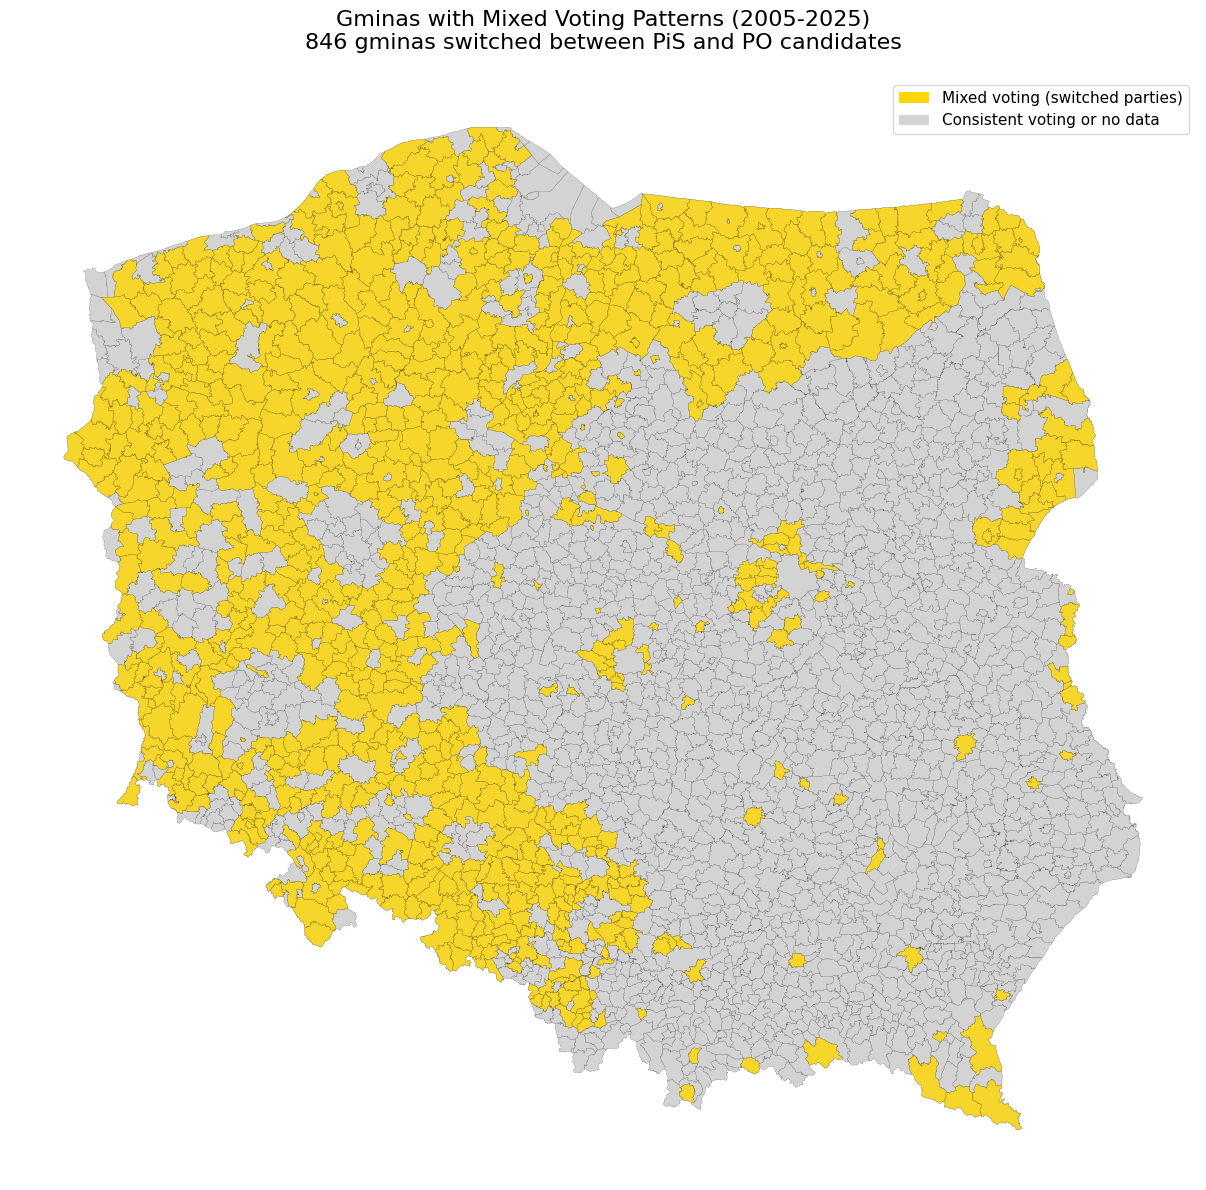

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load municipality boundaries
gml_path = 'datasets/ms_A03_Granice_gmin.gml'
municipalities = gpd.read_file(gml_path)
municipalities['TERYT_6'] = municipalities['JPT_KOD_JE'].astype(str).str.strip().str[:6]

# Initialize a dictionary to store voting patterns
voting_patterns = {}

# Process 2005 election data
file_path = 'datasets/2005/2005.xls'
election_data_2005 = pd.read_excel(file_path, skiprows=2)
election_data_2005.columns = [
    'TERYT', 'Gmina', 'Powiat',
    'Uprawnieni', 'Karty_wydane', 'Karty_wydane_proc',
    'Glosy_oddane', 'Glosy_niewazne', 'Glosy_niewazne_proc',
    'Glosy_wazne', 'Glosy_wazne_proc',
    'Kaczynski_liczba', 'Kaczynski_proc',
    'Tusk_liczba', 'Tusk_proc'
]
election_data_2005 = election_data_2005[election_data_2005['TERYT'].notna()]
election_data_2005['TERYT_6'] = election_data_2005['TERYT'].astype(str).str.strip().str.zfill(6)
election_data_2005['winner_2005'] = election_data_2005.apply(
    lambda row: 'PiS' if row['Kaczynski_liczba'] > row['Tusk_liczba'] else 'PO',
    axis=1
)
for _, row in election_data_2005.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2005'] = row['winner_2005']

# Process 2010 election data
file_path = 'datasets/2010/pzt2010-wyn-gmn.csv'
election_data_2010 = pd.read_csv(file_path, sep=';', encoding='cp1250')
election_data_2010.columns = [
    'Kod_woj', 'Wojewodztwo', 'Kod_gm', 'Gmina', 'Typ_gminy', 'Powiat',
    'L_obwodow', 'Uprawnieni', 'Wydane_karty', 'Glosy_oddane', 'Glosy_wazne',
    'Kaczynski_glosy', 'Komorowski_glosy'
]
election_data_2010['TERYT_6'] = election_data_2010['Kod_gm'].astype(str).str.zfill(6)
election_data_2010['winner_2010'] = election_data_2010.apply(
    lambda row: 'PiS' if row['Kaczynski_glosy'] > row['Komorowski_glosy'] else 'PO',
    axis=1
)
for _, row in election_data_2010.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2010'] = row['winner_2010']

# Process 2015 election data
file_path_2015 = 'datasets/2015/wyniki_tura2.xls'
election_data_2015 = pd.read_excel(file_path_2015)
municipality_results_2015 = election_data_2015.groupby('Gmina').agg({
    'Andrzej Sebastian Duda': 'sum',
    'Bronisław Maria Komorowski': 'sum'
}).reset_index()
municipality_results_2015['winner'] = municipality_results_2015.apply(
    lambda row: 'PiS' if row['Andrzej Sebastian Duda'] > row['Bronisław Maria Komorowski'] else 'PO',
    axis=1
)
# Map TERYT codes using 2010 data
file_path_2010 = 'datasets/2010/pzt2010-wyn-gmn.csv'
data_2010 = pd.read_csv(file_path_2010, sep=';', encoding='cp1250')
teryt_mapping = {}
for _, row in data_2010.iterrows():
    gmina_name = row['Gmina']
    if gmina_name.endswith(', m.'):
        gmina_name = 'm. ' + gmina_name[:-4]
    elif gmina_name.endswith(', gm.'):
        gmina_name = 'gm. ' + gmina_name[:-5]
    teryt_mapping[gmina_name] = str(row['Kod gm.']).zfill(6)
municipality_results_2015['TERYT_6'] = municipality_results_2015['Gmina'].map(teryt_mapping)
for _, row in municipality_results_2015[municipality_results_2015['TERYT_6'].notna()].iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2015'] = row['winner']

# Process 2020 election data
file_path = 'datasets/2020/wyniki_gl_na_kand_po_gminach_utf8.csv'
election_data_2020 = pd.read_csv(file_path, sep=';')
municipality_results_2020 = election_data_2020.groupby(['Kod TERYT', 'Gmina']).agg({
    'Andrzej Sebastian DUDA': 'sum',
    'Rafał Kazimierz TRZASKOWSKI': 'sum'
}).reset_index()
municipality_results_2020['TERYT_6'] = municipality_results_2020['Kod TERYT'].astype(str).str.zfill(6)
municipality_results_2020['winner_2020'] = municipality_results_2020.apply(
    lambda row: 'PiS' if row['Andrzej Sebastian DUDA'] > row['Rafał Kazimierz TRZASKOWSKI'] else 'PO',
    axis=1
)
for _, row in municipality_results_2020.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2020'] = row['winner_2020']

# Process 2025 election data
file_path = 'datasets/2025/wyniki_gl_na_kandydatow_po_gminach_w_drugiej_turze_utf8.csv'
election_data_2025 = pd.read_csv(file_path, sep=';', quotechar='"')
election_data_2025 = election_data_2025[election_data_2025['TERYT Gminy'].notna()]
election_data_2025['TERYT_6'] = election_data_2025['TERYT Gminy'].astype(str).str.replace('.0', '').str.zfill(6)
municipality_results_2025 = election_data_2025.groupby(['TERYT_6', 'Gmina']).agg({
    'NAWROCKI Karol Tadeusz': 'sum',
    'TRZASKOWSKI Rafał Kazimierz': 'sum'
}).reset_index()
municipality_results_2025['winner_2025'] = municipality_results_2025.apply(
    lambda row: 'PiS' if row['NAWROCKI Karol Tadeusz'] > row['TRZASKOWSKI Rafał Kazimierz'] else 'PO',
    axis=1
)
for _, row in municipality_results_2025.iterrows():
    teryt = row['TERYT_6']
    if teryt not in voting_patterns:
        voting_patterns[teryt] = {}
    voting_patterns[teryt]['2025'] = row['winner_2025']

# Analyze voting patterns to find mixed gminas
mixed = []
mixed_patterns = {}

for teryt, votes in voting_patterns.items():
    elections = ['2005', '2010', '2015', '2020', '2025']
    available_elections = [e for e in elections if e in votes]

    if len(available_elections) == 5:  # Has data for all elections
        unique_votes = set(votes[e] for e in available_elections)
        if len(unique_votes) > 1:  # Has voted for both PiS and PO
            mixed.append(teryt)
            # Calculate PiS vs PO wins
            pis_wins = sum(1 for e in available_elections if votes[e] == 'PiS')
            po_wins = sum(1 for e in available_elections if votes[e] == 'PO')
            mixed_patterns[teryt] = {'pis_wins': pis_wins, 'po_wins': po_wins}

print(f"\nGminas with mixed voting patterns: {len(mixed)}")

# Breakdown of mixed patterns
if mixed_patterns:
    print("\nMixed voting patterns breakdown:")
    pattern_counts = {}
    for teryt, pattern in mixed_patterns.items():
        key = f"PiS: {pattern['pis_wins']}, PO: {pattern['po_wins']}"
        pattern_counts[key] = pattern_counts.get(key, 0) + 1
    for pattern, count in sorted(pattern_counts.items()):
        print(f"  {pattern}: {count} gminas")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot all municipalities in gray
municipalities.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

# Plot mixed voting gminas in yellow
municipalities['mixed'] = municipalities['TERYT_6'].isin(mixed)
municipalities[municipalities['mixed']].plot(ax=ax, color='#FFD700', edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title
ax.set_title(f'Gminas with Mixed Voting Patterns (2005-2025)\n{len(mixed)} gminas switched between PiS and PO candidates',
             fontsize=16, pad=20)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFD700', label='Mixed voting (switched parties)'),
    Patch(facecolor='lightgray', label='Consistent voting or no data')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()
